In [1]:
# 사용 커널 Pyton 3.10.13
# 사용 데이터 : 전국대학별등록금정보표준데이터 URL : https://www.data.go.kr/data/15107738/standard.do
# 분석 목적 : 일반적으로 대학의 유형에 따라 등록금 액수가 나뉜다는 인식이 있기 때문에 이를 확인하고자 선정
# 예상 결과 : 공립 보다는 사립이, 일반 대학 보다는 대학원이 등록금이 더 높을 것으로 예상
# 데이터 설명 : 대학교명, 대학 구분, 설립 형태, 평균등록금액 등의 12개 속성, 923개 데이터 이를 등록금 액수에 따라 그룹화 하고, 각 그룹과 대학 형태를 구분하여 연관성을 시각화 할 수 있다.


Initial data:
   기준연도  시도코드                시도명              대학구분명                대학교명  \
0  2023    41        Gyeonggi-do         University              가톨릭대학교   
1  2023    11              Seoul    Graduate School            한국외국어대학교   
2  2023    26              Busan  Technical College  한국폴리텍 VII 대학 부산캠퍼스   
3  2023    31              Ulsan  Technical College  한국폴리텍 VII 대학 울산캠퍼스   
4  2023    44  Chungcheongnam-do         University              남서울대학교   

  본분교구분명  설립형태구분명     평균입학금액     평균등록금액     데이터기준일자   제공기관코드   제공기관명  
0     본교  Private        0.0  7071831.5  2023-10-31  B552529  한국장학재단  
1     본교  Private  1070000.0  9520920.6  2023-10-31  B552529  한국장학재단  
2     본교  Private        0.0  2432000.0  2023-10-31  B552529  한국장학재단  
3     본교  Private        0.0  2432000.0  2023-10-31  B552529  한국장학재단  
4     본교  Private        0.0  7924048.8  2023-10-31  B552529  한국장학재단  


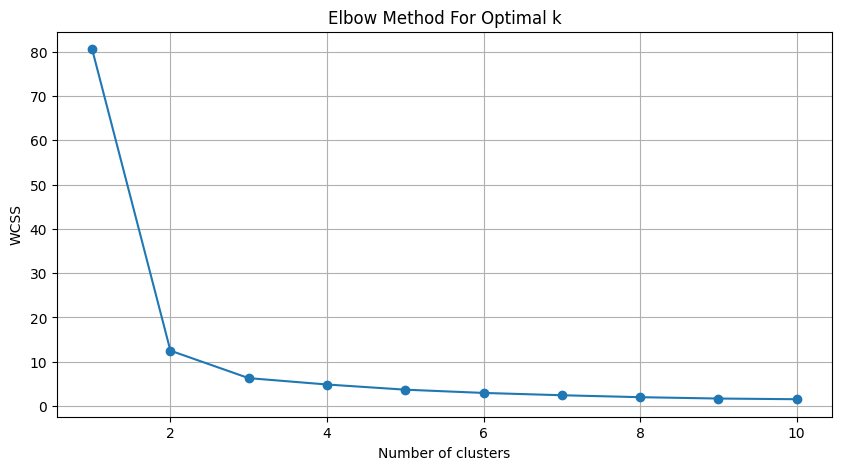

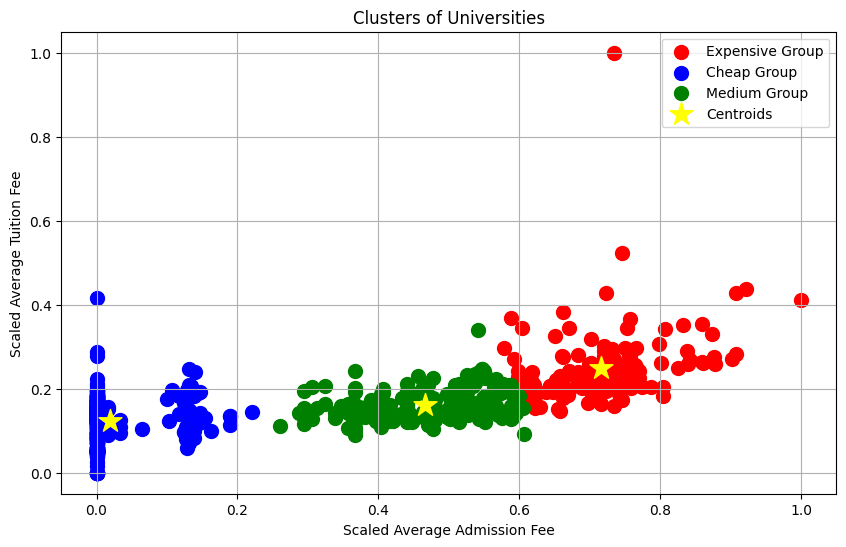

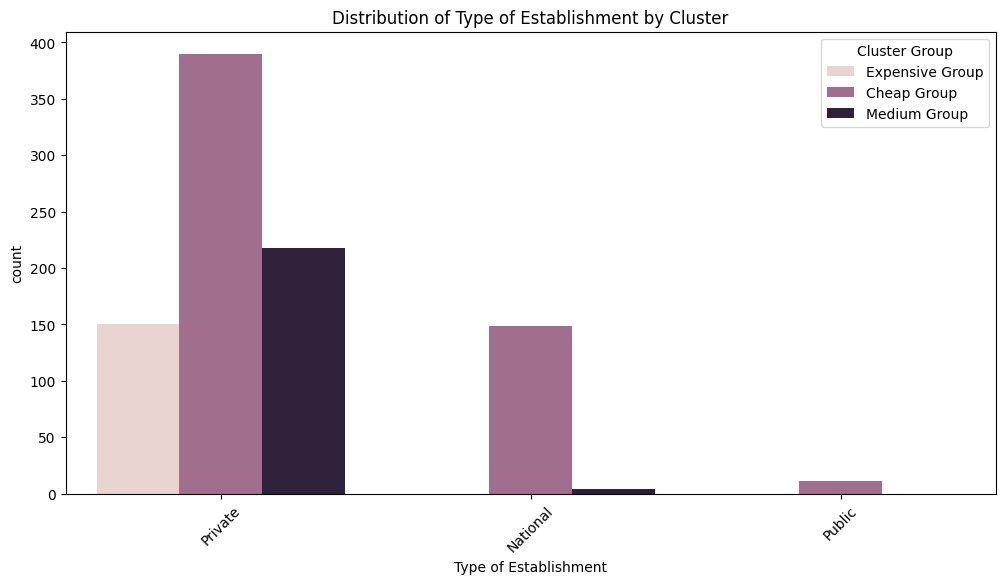

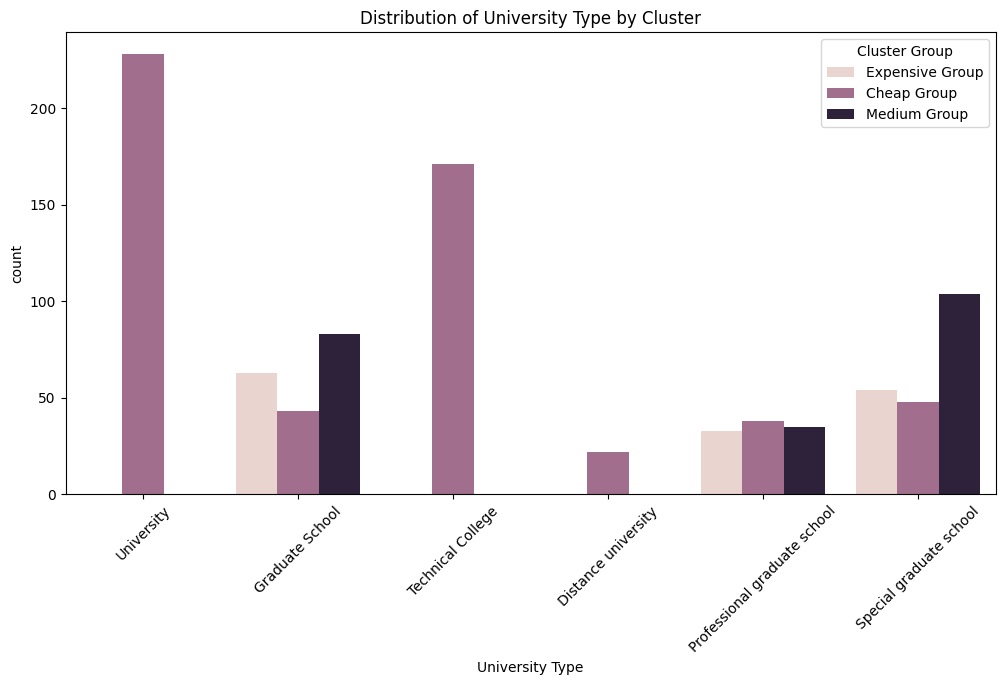

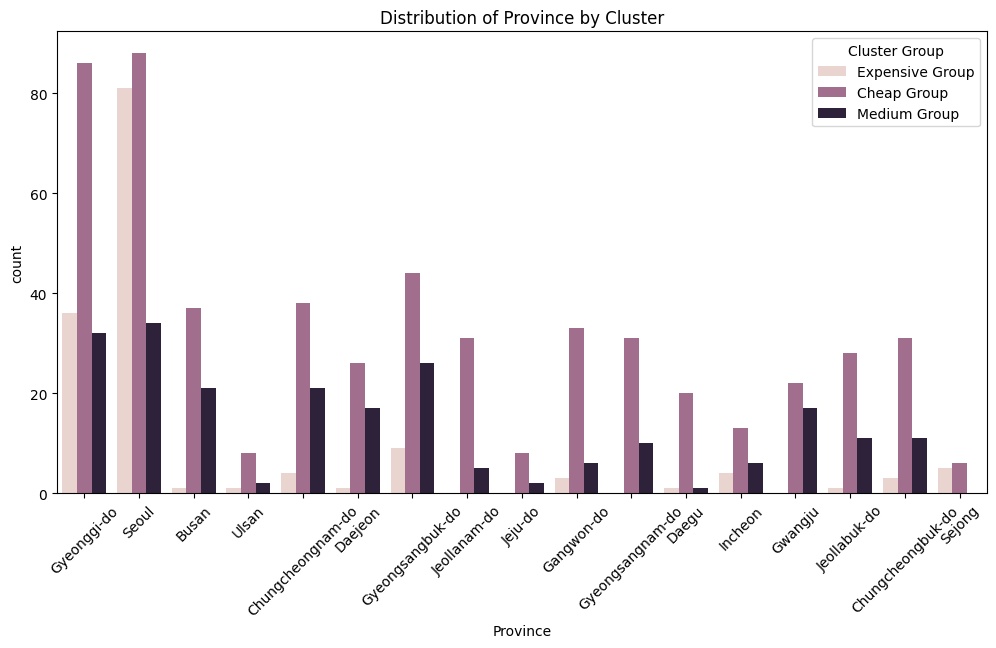

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import seaborn as sns

# 데이터 로드
data = pd.read_csv('전국대학별등록금정보표준데이터.csv', encoding='CP949')

# 코드 스페이스에서 한글이 안나와서 영어로 바꿈
type_of_establishment_mapping = {
    '사립': 'Private',
    '국립': 'National',
    '공립': 'Public'
}

university_type_mapping = {
    '대학': 'University',
    '원격대학' : 'Distance university',
    '일반대학원' : 'Graduate School',
    '전문대학': 'Technical College',
    '전문대학원': 'Professional graduate school',
    '특수대학원' : 'Special graduate school'
}

province_mapping = {
    '서울특별시': 'Seoul',
    '부산광역시': 'Busan',
    '대구광역시': 'Daegu',
    '인천광역시': 'Incheon',
    '광주광역시': 'Gwangju',
    '대전광역시': 'Daejeon',
    '울산광역시': 'Ulsan',
    '세종특별자치시': 'Sejong',
    '경기도': 'Gyeonggi-do',
    '강원특별자치도': 'Gangwon-do',
    '충청북도': 'Chungcheongbuk-do',
    '충청남도': 'Chungcheongnam-do',
    '전라북도': 'Jeollabuk-do',
    '전라남도': 'Jeollanam-do',
    '경상북도': 'Gyeongsangbuk-do',
    '경상남도': 'Gyeongsangnam-do',
    '제주특별자치도': 'Jeju-do'
}

# 데이터 매핑 적용
data['설립형태구분명'] = data['설립형태구분명'].replace(type_of_establishment_mapping)
data['대학구분명'] = data['대학구분명'].replace(university_type_mapping)
data['시도명'] = data['시도명'].replace(province_mapping)

# 데이터의 처음 몇 행을 출력하여 로드된 데이터 확인
print("Initial data:")
print(data.head())

# 결측치 제거
data.dropna(inplace=True)

# 클러스터링에 사용할 변수 선택
data_for_clustering = data[['평균입학금액', '평균등록금액']]

# 데이터 스케일링 (MinMax Scaling)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_for_clustering)

# 엘보우 방법을 사용하여 최적의 K 결정
wcss = []
for i in range(1, 11):  # 1부터 10까지 K 값을 시도
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(data_scaled)
    wcss.append(kmeans.inertia_)

# WCSS 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

# K = 3으로 클러스터링 수행
kmeans_final = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
data['Cluster'] = kmeans_final.fit_predict(data_scaled)

# 클러스터링 결과 시각화
plt.figure(figsize=(10, 6))
plt.scatter(data_scaled[data['Cluster'] == 0, 0], data_scaled[data['Cluster'] == 0, 1], s=100, c='red', label='Expensive Group')
plt.scatter(data_scaled[data['Cluster'] == 1, 0], data_scaled[data['Cluster'] == 1, 1], s=100, c='blue', label='Cheap Group')
plt.scatter(data_scaled[data['Cluster'] == 2, 0], data_scaled[data['Cluster'] == 2, 1], s=100, c='green', label='Medium Group')
plt.scatter(kmeans_final.cluster_centers_[:, 0], kmeans_final.cluster_centers_[:, 1], s=300, c='yellow', marker='*', label='Centroids')
plt.title('Clusters of Universities')
plt.xlabel('Scaled Average Admission Fee')
plt.ylabel('Scaled Average Tuition Fee')
plt.legend()
plt.grid(True)
plt.show()

# 클러스터와 다른 속성과의 관계 분석
# 속성명을 영어로 번역
data.rename(columns={'설립형태구분명': 'Type of Establishment', '대학구분명': 'University Type', '시도명': 'Province'}, inplace=True)

cluster_labels = {0: 'Expensive Group', 1: 'Cheap Group', 2: 'Medium Group'}
data['Cluster Label'] = data['Cluster'].map(cluster_labels)

for attribute in ['Type of Establishment', 'University Type', 'Province']:
    plt.figure(figsize=(12, 6))
    sns.countplot(x=attribute, hue='Cluster', data=data)
    plt.title(f'Distribution of {attribute} by Cluster')
    plt.xticks(rotation=45)
    legend_labels = ['Expensive Group', 'Cheap Group', 'Medium Group']
    plt.legend(title='Cluster Group', labels=legend_labels)
    plt.show()

In [3]:
#클러스터 분석 : 입학금과 등록금은 거의 동일한 추세를 가짐. 저렴한 그룹, 중간 그룹, 비싼 그룹 3개 그룹으로 나누었음
#평가 : 실루엣 점수가 0.7로 준수한 수준이며, 실제로 학비로 그룹화가 가능함을 나타냄.
#국공립 대학교에는 비싼 그룹의 학교가 없고 사립의 경우에는 비싼 그룹과 중간 그룹이 유의미하게 분포해있어 사립이 상대적으로 비싸다는 일반적 인식이 사실임을 나타냄.
#대학교 그룹에 비해 대학원 그룹이 확실하게 비싼 모습을 보임.
#서울 소재 대학들의 학비가 비싼편이 많음을 알 수 있음

from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(data_scaled, data['Cluster'])
print(f'Average Silhouette Score: {silhouette_avg}')

Average Silhouette Score: 0.7077069358424338
